# Interatomic force field (IFF) optimization for W-based metal alloys

## Calculate configuration statistics for EAM models

Author: Lukas Vlcek

Start Date: 2018-04-22

In [1]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-09-13 22:32:15.036579


In [56]:
%matplotlib inline
import os
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

# source of raw data and destination for processed data
target_proc = '../data/target_processed'

**Read a list of trajectory datasets for processing**

In [57]:
with open(os.path.join(target_proc,  "datasets_filtered.pickle"), 'rb') as fi:
    datasets = pickle.load(fi)
    print(datasets)

['bcc_npt_langevin_300K_filtered', 'fcc_npt_langevin_300K_filtered', 'vac_npt_langevin_2000K_filtered', 'i110_npt_langevin_2000K_filtered', 'i111_npt_langevin_2000K_filtered', 'screw_111_npt_langevin_2000K_filtered', 'bcc_npt_langevin_3700K_filtered', 'liq_3700K_filtered', 'liq_5000K_filtered']


In [58]:
datasets.append('structs_0k')

In [59]:
datasets

['bcc_npt_langevin_300K_filtered',
 'fcc_npt_langevin_300K_filtered',
 'vac_npt_langevin_2000K_filtered',
 'i110_npt_langevin_2000K_filtered',
 'i111_npt_langevin_2000K_filtered',
 'screw_111_npt_langevin_2000K_filtered',
 'bcc_npt_langevin_3700K_filtered',
 'liq_3700K_filtered',
 'liq_5000K_filtered',
 'structs_0k']

In [62]:
trajectories = []
for dset in datasets:
    with open(os.path.join(target_proc, dset + ".pickle"), 'rb') as fo:
        trajectories.append(pickle.load(fo))

In [60]:
#with open(os.path.join(target_proc, 'structs_0k' + ".pickle"), 'rb') as fo:
#    structs0k = pickle.load(fo)
        #trajectories.append(pickle.load(fo))

In [63]:
#structs0k

Function to calculate atom pair distances in a triclinic box

In [64]:
def pair_dist_triclinic(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : numpy 2D array of unit cell vectors or a float
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """
    
    # make sure that the box is a 3x3 matrix (if box is float, multiply it by a unit matrix)
    box = np.eye(3).dot(box)

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)
    
    boxT = box.T
    
    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5, dp + 1.0, dp)
            dp = np.where(dp >  0.5, dp - 1.0, dp)
            
            dp = boxT.dot(dp)
            
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp

    return rr, rx

In [65]:
# sufficient statistics for EAM
def get_stats_EAM(rr, rx, sc):
    """
    Takes atom pair distances and calculates sufficeint statistics needed
    for the parameterization of a cubic spline-based EAM model by Bonny et al. (2017).
    
    Parameters
    ----------
    rr : numpy array
         set of pair distances
    rx : numpy array
         set of pair distance coordinates
    sc : python list
         spline nodes
         
    Returns
    -------
    ar, a1, a2 : numpy arrays (len(sc))
                 atom energy-related statistics
                 el_density**0.5, el_density, el_density**2
    br, b1, b2 : numpy arrays (len(sc), natoms, 3 coordinates)
                 atom force-related statistics (gradients of energy)
                 grad(el_density**0.5), grad(el_density), grad(el_density**2)
    """

    n_atom = rr.shape[0]

    # energy-related statistics
    aa = np.empty((n_atom), dtype=float)
    ar = np.zeros((len(sc)), dtype=float)
    a1 = np.zeros_like(ar)
    a2 = np.zeros_like(ar)

    # force-related statistics
    br = np.zeros((len(sc), n_atom, 3), dtype=float)
    b1 = np.zeros_like(br)
    b2 = np.zeros_like(br)
    zero3 = np.zeros((3))

    # cycle over spline nodes
    for ks, rc in enumerate(sc):

        # cycle over atoms
        for i in range(n_atom):

            # sum electronic density over all neighbors of i within rc
            aa[i] = sum([(rc - r)**3 for r in rr[i] if (r < rc and r > 0.01)])

            # if el. density larger than zero, calculate force statistics                                                                                                                                        84,0-1        43%
            if aa[i] > 0.0:

                # precompute a list of recurring values for force statistics
                ff = [1.5*(rc - r)**2*x/r if (r > 0.01 and r < rc) else zero3 for r, x in zip(rr[i], rx[i])]

                # sum contributions to force statistics from all neighbors of i
                b1[ks, i] = sum([2*f       for f in ff])
                br[ks, i] = sum([ -f/np.sqrt(aa[i]) for f in ff])
                b2[ks, i] = sum([4*f*aa[i] for f in ff])

        # sum contributions to energy statistics for a given spline node
        ar[ks] = np.sum(np.sqrt(aa))
        a1[ks] = np.sum(aa)
        a2[ks] = np.sum(aa**2)

    return a1, ar, a2, b1, br, b2

**Calculate pair distances and energy statistics**

Force statistics not calculated for longer MD trajectories.

dataset # 0
conf 0
conf 1
conf 2
conf 3
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15
conf 16
conf 17
conf 18
conf 19
conf 20
conf 21
conf 22
conf 23
conf 24
conf 25
conf 26
conf 27
conf 28
conf 29
conf 30
conf 31
conf 32
conf 33
conf 34
conf 35
conf 36
conf 37
conf 38
conf 39
conf 40
conf 41
conf 42
conf 43
conf 44
conf 45
conf 46
conf 47
conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75
conf 76
conf 77
conf 78
conf 79
conf 80
conf 81
conf 82
conf 83
conf 84
conf 85
conf 86
conf 87
conf 88
conf 89
conf 90
conf 91
conf 92
conf 93
conf 94
conf 95
conf 96
conf 97
conf 98
conf 99
conf 100
conf 101
conf 102
conf 103
conf 104
conf 105
conf 106
conf 107
conf 108
conf 109
conf 110
conf 111
conf 112
conf 113
conf 114
conf 115
conf 116
conf 117
conf 118
conf 119
dataset # 1
conf 0

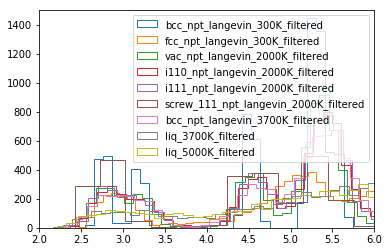

In [70]:
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
weights = [1.0 for _ in range(len(trajectories))]
weights[-1] = 10.0

stats_data = {}
target_data = {}

for di, (traj, weight) in enumerate(zip(trajectories, weights)):
    
    print('dataset #', di)

    # target data
    target_dict = {'type':'trajectory', 'weight':weight}
    target_dict['box'] = traj['box']
    target_dict['xyz'] = traj['xyz']
    target_dict['energy'] = traj['energy']
    target_dict['temp'] = traj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp
            
    target_data['dset'+str(di)] = target_dict

    # statistics data
    stats_dict = {'energy':[]}
    for ii, (xyz, box) in enumerate(zip(traj['xyz'], traj['box'])):
        print('conf', ii)
        
        rr, rx = pair_dist_triclinic(xyz, box)

        a1, ar, a2, f1, fr, f2 = get_stats_EAM(rr, rx, sc)
        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))

        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        if ii == 10:
            plt.hist(rr.flatten(),100, alpha=1.0,label=datasets[di], histtype='step')
            plt.xlim(2,6)
            plt.ylim(0,1500)
            
    plt.legend()
    stats_data['dset'+str(di)] = stats_dict

In [71]:
# pickle stats and target data to be used for optimization
with open('../data/working/target_filtered.pickle', 'wb') as fo:
    pickle.dump(target_data, fo)

with open('../data/working/stats_filtered.pickle', 'wb') as fo:
    pickle.dump(stats_data, fo)

Make combined reference datasets